# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/ai/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://codereview.stackexchange.com/questions/19663/http-url-validating
i, j = 0 , 0
for test in (final['Text'].values):
  i = i + 1
  if re.match('https?://(?:www)?(?:[\w-]{2,255}(?:\.\w{2,6}){1,2})(?:/[\w&%?#-]{1,300})?',test):
      print(test)
      print("indes = ",i)
      print("="*50)
      j = j + 1
      if j == 5:
        break;

http://www.amazon.com/gp/product/B0002XEI9O/ref=cm_cr_rev_prod_title<br /><br />So far, the Sprout Bag is good for growing various legume / bean - Sprouts. I am also using the bag to store the completed product in the refrigerator.  A second hanging handle, at the top, would be helpful.
indes =  18044
http://www.amazon.com/gp/product/B000ER3EFC/ref=cm_cr_rev_prod_img<br /><br />I don't have a baby, but I am on soft foods for a while after stomach surgery. I ordered some baby foods from Amazon and promptly found out why my babies never would eat baby food. This is supposedly sweet potatoes, but they found a way to remove all the earthy goodness. Before I added salt it tasted like nothing eaten by a human; with salt, it tasted like very mild carrots. I suppose I will eventually use it in baking, but frankly, if it's sweet potatoes I never want to meet the strain of sweet potatoes it came from.
indes =  53187
http://www.amazon.com/gp/product/B000MVGVY6/ref=cm_cr_rev_prod_img<br /><br />I 

In [0]:
# printing some urls test reviews
sent_18044 = final['Text'].values[18044 - 1]
print(sent_18044)
print("="*50)

sent_53187 = final['Text'].values[53187 - 1]
print(sent_53187)
print("="*50)

sent_104802 = final['Text'].values[104802 - 1]
print(sent_104802)
print("="*50)

sent_123863 = final['Text'].values[123863 - 1]
print(sent_123863)
print("="*50)

http://www.amazon.com/gp/product/B0002XEI9O/ref=cm_cr_rev_prod_title<br /><br />So far, the Sprout Bag is good for growing various legume / bean - Sprouts. I am also using the bag to store the completed product in the refrigerator.  A second hanging handle, at the top, would be helpful.
http://www.amazon.com/gp/product/B000ER3EFC/ref=cm_cr_rev_prod_img<br /><br />I don't have a baby, but I am on soft foods for a while after stomach surgery. I ordered some baby foods from Amazon and promptly found out why my babies never would eat baby food. This is supposedly sweet potatoes, but they found a way to remove all the earthy goodness. Before I added salt it tasted like nothing eaten by a human; with salt, it tasted like very mild carrots. I suppose I will eventually use it in baking, but frankly, if it's sweet potatoes I never want to meet the strain of sweet potatoes it came from.
http://www.amazon.com/gp/product/B000MVGVY6/ref=cm_cr_rev_prod_img<br /><br />I have been in Utah over 25 year

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_18044 = re.sub(r"http\S+", "", sent_18044)
sent_53187= re.sub(r"http\S+", "", sent_53187)
sent_104802 = re.sub(r"http\S+", "", sent_104802)
sent_123863 = re.sub(r"http\S+", "", sent_123863)

print(sent_18044)
print("="*40)
print(sent_123863)

 /><br />So far, the Sprout Bag is good for growing various legume / bean - Sprouts. I am also using the bag to store the completed product in the refrigerator.  A second hanging handle, at the top, would be helpful.
 /><br />This product is supposed to be the "Herbal Revive"  version but it does not exist in the Amazon inventory.  The one they distribute is "regular" lemon and ginger tea which does not have the same sharp flavor as the Herbal Revive.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_18044, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_53187, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_104802, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_123863, 'lxml')
text = soup.get_text()
print(text)

/>So far, the Sprout Bag is good for growing various legume / bean - Sprouts. I am also using the bag to store the completed product in the refrigerator.  A second hanging handle, at the top, would be helpful.
/>I don't have a baby, but I am on soft foods for a while after stomach surgery. I ordered some baby foods from Amazon and promptly found out why my babies never would eat baby food. This is supposedly sweet potatoes, but they found a way to remove all the earthy goodness. Before I added salt it tasted like nothing eaten by a human; with salt, it tasted like very mild carrots. I suppose I will eventually use it in baking, but frankly, if it's sweet potatoes I never want to meet the strain of sweet potatoes it came from.
/>I have been in Utah over 25 years, at an altitude of about 4200 feet. My internist says that's not too high, but from all I can learn from family history, history, protohistory, and prehistory, my ancestors for at least 10,000 years have lived at or near sea lev

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_18044 = decontracted(sent_18044)
print(sent_18044)
print("="*50)
sent_53187 = decontracted(sent_53187)
print(sent_53187)
print("="*50)
sent_123863 = decontracted(sent_123863)
print(sent_123863)
print("="*50)

 /><br />So far, the Sprout Bag is good for growing various legume / bean - Sprouts. I am also using the bag to store the completed product in the refrigerator.  A second hanging handle, at the top, would be helpful.
 /><br />I do not have a baby, but I am on soft foods for a while after stomach surgery. I ordered some baby foods from Amazon and promptly found out why my babies never would eat baby food. This is supposedly sweet potatoes, but they found a way to remove all the earthy goodness. Before I added salt it tasted like nothing eaten by a human; with salt, it tasted like very mild carrots. I suppose I will eventually use it in baking, but frankly, if it is sweet potatoes I never want to meet the strain of sweet potatoes it came from.
 /><br />This product is supposed to be the "Herbal Revive"  version but it does not exist in the Amazon inventory.  The one they distribute is "regular" lemon and ginger tea which does not have the same sharp flavor as the Herbal Revive.


In [0]:
# https://codereview.stackexchange.com/questions/19663/http-url-validating
i, j = 0 , 0
for test in (final['Text'].values):
  i = i + 1
  if re.match("\S*\d\S*",test):
      print(test)
      print("indes = ",i)
      print("="*50)
      j = j + 1
      if j == 5:
        break;

[[ASIN:B001AGXEAG Beetlejuice (20th Anniversary Deluxe Edition)]<br /><br />Beetlejuice, the Tim Burton classic from 1988 now comes to you packaged as a 20th Anniversary DVD edition.  Michael Keaton, I think in one of his best film performances brings down the house.  Also starring Geena Davis and Alec Baldwin, two actors you would have never thought to put together in a movie of this genre, it is classic comedy at its best.  The DVD also has special features, although nothing to make your head spin, but it offers several episodes of the cartoon series from the late 1980's.  But beyond that, nothing too spectacular; not that it needs that much more. A simple classic comedy that if it doesn't make you laugh, something is wrong with you and you should be exorcised!  With that being said, buy it if you don't own it. It's a must have dark comedy.
indes =  391
1st day, few stupid flies went in. 2nd day, it smell so so bad, had it relocated... 4th day, hundreds flies... OMG. It works so grea

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent = final['Text'].values[2805 - 1]
print(sent)

24 packs for $19.94 comes to .83 per pack.  That is a bargain and does not even consider the subscribe and save 15% discount which would amount to a price of $16.95 or .71 per pack.  Purchasing a single pack on the Amazon site costs $6.79 (plus shipping if you don't qualify for Super Saver).  In addition, at least Amazon has these available.  I could not find them in any store.<br /><br />P.S.  I plan to drink a lot of coffee.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent = re.sub("\S*\d\S*", "", sent).strip()
print(sent)

packs for  comes to  per pack.  That is a bargain and does not even consider the subscribe and save  discount which would amount to a price of  or  per pack.  Purchasing a single pack on the Amazon site costs  (plus shipping if you don't qualify for Super Saver).  In addition, at least Amazon has these available.  I could not find them in any store.<br /><br />P.S.  I plan to drink a lot of coffee.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_18044 = re.sub('[^A-Za-z0-9]+', ' ', sent_18044)
print(sent_18044)

 br So far the Sprout Bag is good for growing various legume bean Sprouts I am also using the bag to store the completed product in the refrigerator A second hanging handle at the top would be helpful 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:38<00:00, 2298.24it/s]


In [0]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.
## Similartly you can do preprocessing for review summary also.
preprocessed_reviews_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_summary.append(sentance.strip())

100%|██████████| 364171/364171 [01:46<00:00, 3419.59it/s]


In [0]:
preprocessed_reviews_summary[1500]

'would best canola oil left'

In [0]:
# adding new columns ["CleanedText", "CleanedSummary"] to the data frame and save that data frame as "preprocessed.pkl"
final["CleanedText"] = preprocessed_reviews
final["CleanedSummary"] = preprocessed_reviews_summary
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
178145,193174,B009RSR8HO,A4P6AN2L435PV,romarc,0,0,1,1350432000,LOVE!! LOVE!!,"LOVE, LOVE this sweetener!! I use it in all m...",love love sweetener use baking unsweetened fla...,love love
173675,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,1,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...,try sauce believe starts little sweet honey ta...,amazing great sauce everything
204727,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,1,1350604800,Awesome Taste,I bought this Hazelnut Paste (Nocciola Spread)...,bought hazelnut paste nocciola spread local sh...,awesome taste
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...,delicious
302474,327601,B009WVB40S,A3ME78KVX31T21,K'la,0,0,1,1351123200,Tasty!,I purchased this to send to my son who's away ...,purchased send son away college delivered righ...,tasty


In [0]:
# save the data frame as "preprocessed.pkl"
final.to_pickle("drive/ai/preprocessed.pkl")

# [4] Featurization

**I am used to select 50k data points randaand sord them using time based splitting** 

In [0]:
# Split the data into train , test and crossvalidation datasets
# load "preprocessed.pkl" data frame
df = pd.read_pickle("drive/ai/preprocessed.pkl")
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational


In [0]:
df.shape

(364171, 12)

In [0]:
# take 50k sample data randomly
sample_data = df.sample(50000)
sample_data.shape

(50000, 12)

In [0]:
# sorted the data using time based
sorted_data = sample_data.sort_values('Time', axis=0, inplace=False)
sorted_data.shape

(50000, 12)

In [0]:
sorted_data['Score'].value_counts()

1    42277
0     7723
Name: Score, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X = np.array(sorted_data['CleanedText'])
y = np.array(sorted_data['Score'])
print(X.shape)
print(y.shape)

(50000,)
(50000,)


In [0]:
# Simple cross validation
# split the data sent into train and test
train , test , train_y , test_y = train_test_split(X, y, test_size = 0.3, random_state=None)

# split the train data set into cross validation train and cross validation test
train, cv , train_y, cv_y = train_test_split(train, train_y, test_size=0.3, random_state=None)

print("train data = ", train.shape)
print("cros validation = ", cv.shape)
print("test data = ", test.shape)

train data =  (24500,)
cros validation =  (10500,)
test data =  (15000,)


## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_train = count_vect.fit_transform(train)
final_counts_cv = count_vect.transform(cv)
final_counts_test = count_vect.transform(test)
print("============Train Data=========")
print("the type of count vectorizer ",type(final_counts_train))
print("the shape of out text BOW vectorizer ",final_counts_train.get_shape())
print("the number of unique words ", final_counts_train.get_shape()[1])
print("============Cross validation Data=========")
print("the type of count vectorizer ",type(final_counts_cv))
print("the shape of out text BOW vectorizer ",final_counts_cv.get_shape())
print("the number of unique words ", final_counts_cv.get_shape()[1])
print("============Test Data=========")
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaaaarrrrrggghhh', 'aaah', 'aaahhhs', 'aabsolutely', 'aafco', 'aafes', 'aah', 'aamazon']
============Train Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (24500, 30806)
the number of unique words  30806
============Cross validation Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10500, 30806)
the number of unique words  30806
============Test Data=========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (15000, 30806)
the number of unique words  30806


In [0]:
# the time of bagofwords is sparse matrix now convert to lower dimensions
# Dimensionality reduction using truncated SVD
from sklearn.decomposition import TruncatedSVD

bagofwords_svd = TruncatedSVD(n_components= 500) #Desired dimensionality of output data

bow_train = bagofwords_svd.fit_transform(final_counts_train)
print('Explained Variance Ratio is = %0.2f%%'% (bagofwords_svd.explained_variance_ratio_.sum() * float(100)))
bow_cv = bagofwords_svd.fit_transform(final_counts_cv)
bow_test = bagofwords_svd.fit_transform(final_counts_test)
print("trian data shape = ", bow_train.shape)
print("CV data shape = ", bow_cv.shape)
print("test data shape = ", bow_test.shape)

Explained Variance Ratio is = 67.43%
trian data shape =  (24500, 500)
CV data shape =  (10500, 500)
test data shape =  (15000, 500)


In [0]:
# save the datasets as numpy array
bow_train = np.array(bow_train)
bow_cv = np.array(bow_cv)
bow_test = np.array(bow_test)

In [0]:
np.save("drive/ai/bow_train.npy", bow_train)
np.save("drive/ai/bow_train_y.npy", train_y)
np.save("drive/ai/bow_cv.npy", bow_cv)
np.save("drive/ai/bow_cv_y.npy", cv_y)
np.save("drive/ai/bow_test.npy", bow_test)
np.save("drive/ai/bow_test_y.npy", test_y)

In [0]:
## for kd_tree

## for kd_tree

In [0]:
# the time of bagofwords is sparse matrix now convert to lower dimensions
# Dimensionality reduction using truncated SVD
from sklearn.decomposition import TruncatedSVD

bagofwords_svd = TruncatedSVD(n_components= 200) #Desired dimensionality of output data

bow_train = bagofwords_svd.fit_transform(final_counts_train)
print('Explained Variance Ratio is = %0.2f%%'% (bagofwords_svd.explained_variance_ratio_.sum() * float(100)))
bow_cv = bagofwords_svd.fit_transform(final_counts_cv)
bow_test = bagofwords_svd.fit_transform(final_counts_test)
print("trian data shape = ", bow_train.shape)
print("CV data shape = ", bow_cv.shape)
print("test data shape = ", bow_test.shape)

Explained Variance Ratio is = 50.60%
trian data shape =  (24500, 200)
CV data shape =  (10500, 200)
test data shape =  (15000, 200)


In [0]:
# save the datasets as numpy array
bow_train = np.array(bow_train)
bow_cv = np.array(bow_cv)
bow_test = np.array(bow_test)

In [0]:
np.save("drive/ai/kd_bow_train.npy", bow_train)
np.save("drive/ai/kd_bow_train_y.npy", train_y)
np.save("drive/ai/kd_bow_cv.npy", bow_cv)
np.save("drive/ai/kd_bow_cv_y.npy", cv_y)
np.save("drive/ai/kd_bow_test.npy", bow_test)
np.save("drive/ai/kd_bow_test_y.npy", test_y)

## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("================Train Data===========")
final_tf_idf_train = tf_idf_vect.fit_transform(train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
print("================CV Data===========")
final_tf_idf_cv = tf_idf_vect.transform(cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])
print("================Test Data===========")
final_tf_idf_test = tf_idf_vect.transform(test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make', 'able order']
================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24500, 14443)
the number of unique words including both unigrams and bigrams  14443
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10500, 14443)
the number of unique words including both unigrams and bigrams  14443
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15000, 14443)
the number of unique words including both unigrams and bigrams  14443


In [0]:
# the time of bagofwords is sparse matrix now convert to lower dimensions
# Dimensionality reduction using truncated SVD

tfidf_svd = TruncatedSVD(n_components= 500) #Desired dimensionality of output data

tfidf_train = tfidf_svd.fit_transform(final_tf_idf_train)
print('Explained Variance Ratio is = %0.2f%%'% (tfidf_svd.explained_variance_ratio_.sum() * float(100)))
tfidf_cv = bagofwords_svd.fit_transform(final_tf_idf_cv)
tfidf_test = bagofwords_svd.fit_transform(final_tf_idf_test)
print("trian data shape = ", tfidf_train.shape)
print("CV data shape = ", tfidf_cv.shape)
print("test data shape = ", tfidf_test.shape)

Explained Variance Ratio is = 34.12%
trian data shape =  (24500, 500)
CV data shape =  (10500, 500)
test data shape =  (15000, 500)


In [0]:
# save the datasets as numpy array
tfidf_train = np.array(tfidf_train)
tfidf_cv = np.array(tfidf_cv)
tfidf_test = np.array(tfidf_test)

In [0]:
np.save("drive/ai/tfidf_train.npy", tfidf_train)
np.save("drive/ai/tfidf_train_y.npy", train_y)
np.save("drive/ai/tfidf_cv.npy", tfidf_cv)
np.save("drive/ai/tfidf_cv_y.npy", cv_y)
np.save("drive/ai/tfidf_test.npy", tfidf_test)
np.save("drive/ai/tfidf_test_y.npy", test_y)

## for kd_tree

In [0]:
# the time of bagofwords is sparse matrix now convert to lower dimensions
# Dimensionality reduction using truncated SVD

tfidf_svd = TruncatedSVD(n_components= 200) #Desired dimensionality of output data

tfidf_train = tfidf_svd.fit_transform(final_tf_idf_train)
print('Explained Variance Ratio is = %0.2f%%'% (tfidf_svd.explained_variance_ratio_.sum() * float(100)))
tfidf_cv = bagofwords_svd.fit_transform(final_tf_idf_cv)
tfidf_test = bagofwords_svd.fit_transform(final_tf_idf_test)
print("trian data shape = ", tfidf_train.shape)
print("CV data shape = ", tfidf_cv.shape)
print("test data shape = ", tfidf_test.shape)

Explained Variance Ratio is = 20.69%
trian data shape =  (24500, 200)
CV data shape =  (10500, 200)
test data shape =  (15000, 200)


In [0]:
# save the datasets as numpy array
tfidf_train = np.array(tfidf_train)
tfidf_cv = np.array(tfidf_cv)
tfidf_test = np.array(tfidf_test)

In [0]:
np.save("drive/ai/kd_tfidf_train.npy", tfidf_train)
np.save("drive/ai/kd_tfidf_train_y.npy", train_y)
np.save("drive/ai/kd_tfidf_cv.npy", tfidf_cv)
np.save("drive/ai/kd_tfidf_cv_y.npy", cv_y)
np.save("drive/ai/kd_tfidf_test.npy", tfidf_test)
np.save("drive/ai/kd_tfidf_test_y.npy", test_y)

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
######## Train Set #########
i=0
list_of_train_sentance=[]
for sentance in train:
    list_of_train_sentance.append(sentance.split())
######## CV Set ###########
i=0
list_of_cv_sentance=[]
for sentance in cv:
    list_of_cv_sentance.append(sentance.split())
######## Test Set #########
i=0
list_of_test_sentance=[]
for sentance in test:
    list_of_test_sentance.append(sentance.split())
print("Length of Train = ", len(list_of_train_sentance))
print("Length of CV = ", len(list_of_cv_sentance))
print("Length of Test = ", len(list_of_test_sentance))

Length of Train =  24500
Length of CV =  10500
Length of Test =  15000


In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_model=Word2Vec(list_of_train_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('awesome', 0.8108956813812256), ('excellent', 0.8053444623947144), ('wonderful', 0.803691029548645), ('amazing', 0.8023006916046143), ('good', 0.7889569401741028), ('fantastic', 0.7887020111083984), ('perfect', 0.7716063857078552), ('delicious', 0.708469033241272), ('terrific', 0.6772741675376892), ('nice', 0.6468303203582764)]
[('best', 0.7953071594238281), ('coolest', 0.7594555020332336), ('disgusting', 0.7510324716567993), ('greatest', 0.7498508095741272), ('superior', 0.7156858444213867), ('terrible', 0.7115234732627869), ('awful', 0.688793420791626), ('agree', 0.6859393119812012), ('hooked', 0.6799923181533813), ('ive', 0.6786516308784485)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9882
sample words  ['looked', 'everywhere', 'reviews', 'product', 'buying', 'could', 'not', 'find', 'single', 'one', 'let', 'spare', 'someone', 'situation', 'really', 'good', 'far', 'better', 'expected', 'reading', 'low', 'carb', 'barbecue', 'sauces', 'no', 'negative', 'taste', 'whatsoever', 'sweet', 'tangy', 'completely', 'pleasant', 'would', 'still', 'like', 'lot', 'note', 'grams', 'xylitol', 'per', 'serving', 'know', 'many', 'people', 'try', 'avoid', 'bad', 'said', 'tried', 'cooking']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
######## Train data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_train_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 24500/24500 [00:44<00:00, 551.45it/s]

24500
50


In [0]:
######## CV data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_cv_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 10500/10500 [00:19<00:00, 536.26it/s]

10500
50


In [0]:
######## Test data ########
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_test_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 15000/15000 [00:27<00:00, 551.77it/s]

15000
50


In [0]:
# save the datasets as numpy array
w2v_train = np.array(sent_vectors_train)
w2v_cv = np.array(sent_vectors_cv)
w2v_test = np.array(sent_vectors_test)

In [0]:
np.save("drive/ai/w2v_train.npy", w2v_train)
np.save("drive/ai/w2v_train_y.npy", train_y)
np.save("drive/ai/w2v_cv.npy", w2v_cv)
np.save("drive/ai/w2v_cv_y.npy", cv_y)
np.save("drive/ai/w2v_test.npy", w2v_test)
np.save("drive/ai/w2v_test_y.npy", test_y)

#### [4.4.1.2] TFIDF weighted W2v

In [0]:

model = TfidfVectorizer()
#tf_idf_matrix = model.fit_transform(train)

print("================Train Data===========")
final_tf_idf_train = model.fit_transform(train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])
print("================CV Data===========")
final_tf_idf_cv = model.transform(cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])
print("================Test Data===========")
final_tf_idf_test = model.transform(test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

================Train Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24500, 30961)
the number of unique words including both unigrams and bigrams  30961
================CV Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10500, 30961)
the number of unique words including both unigrams and bigrams  30961
================Test Data===========
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (15000, 30961)
the number of unique words including both unigrams and bigrams  30961


In [0]:
######## Train #######
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_train_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 24500/24500 [08:09<00:00, 50.06it/s]


In [0]:
######## CV #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_cv_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 10500/10500 [03:33<00:00, 49.12it/s]


In [0]:
######## Train #######
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_test_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 15000/15000 [04:52<00:00, 51.23it/s]


In [0]:
# save the datasets as numpy array
tfidf_w2v_train = np.array(train_tfidf_sent_vectors)
tfidf_w2v_cv = np.array(cv_tfidf_sent_vectors)
tfidf_w2v_test = np.array(test_tfidf_sent_vectors)

In [0]:
np.save("drive/ai/w2v_tfidf_train.npy", tfidf_w2v_train)
np.save("drive/ai/w2v_tfidf_train_y.npy", train_y)
np.save("drive/ai/w2v_tfidf_cv.npy", tfidf_w2v_cv)
np.save("drive/ai/w2v_tfidf_cv_y.npy", cv_y)
np.save("drive/ai/w2v_tfidf_test.npy", tfidf_w2v_test)
np.save("drive/ai/w2v_tfidf_test_y.npy", test_y)

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score , f1_score , confusion_matrix
from collections import Counter
from sklearn.metrics import accuracy_score, roc_auc_score , roc_curve
from sklearn.model_selection import train_test_split

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (BOW)
bow_train = np.load("drive/ai/bow_train.npy")
bow_train_y = np.load("drive/ai/bow_train_y.npy")
bow_cv = np.load("drive/ai/bow_cv.npy")
bow_cv_y = np.load("drive/ai/bow_cv_y.npy")
bow_test = np.load("drive/ai/bow_test.npy")
bow_test_y = np.load("drive/ai/bow_test_y.npy")

In [0]:
print("Shape of Train = ", bow_train.shape)
print("Shape of CV = ", bow_cv.shape)
print("Shape of Test = ", bow_test.shape)

Shape of Train =  (24500, 500)
Shape of CV =  (10500, 500)
Shape of Test =  (15000, 500)


In [0]:
bow_train_auc = []
bow_cv_auc = []
for i in range(1,10,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(bow_train, bow_train_y)
  # train data
  y_prob_train = knn.predict_proba(bow_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(bow_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  bow_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(bow_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(bow_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  bow_cv_auc.append(auc_roc_cv)
  
  
  


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 53.47%

Train AUC for k = 3 is 92.31%

CV AUC for k = 3 is 55.03%

Train AUC for k = 5 is 88.99%

CV AUC for k = 5 is 55.29%

Train AUC for k = 7 is 87.13%

CV AUC for k = 7 is 55.61%

Train AUC for k = 9 is 86.04%

CV AUC for k = 9 is 56.72%


In [0]:
k_values = [j for j in range(1,10,2)]

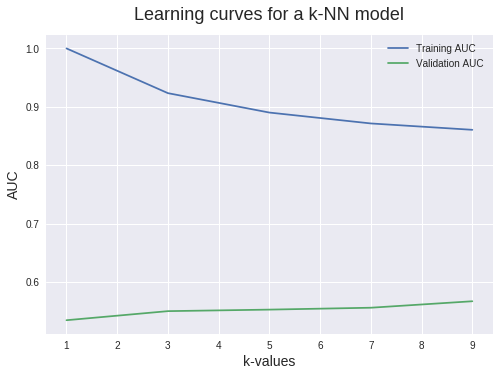

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, bow_train_auc, label = 'Training AUC')
plt.plot(k_values, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(bow_train, bow_train_y)
# train data
y_prob_train = knn.predict_proba(bow_train)[:,1]
fprt, tprt , throsholdt = roc_curve(bow_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(bow_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(bow_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(bow_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(bow_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (9, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(bow_test)[:,1]
fprts, tprts , throsholdts = roc_curve(bow_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(bow_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 9 is 86.04%

CV AUC for k = 9 is 56.72%

Test AUC for k = 9 is 52.45%


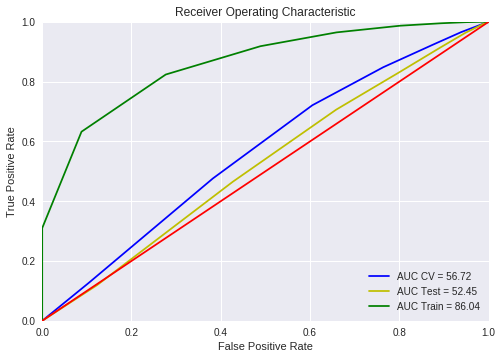

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(bow_test_y, y_pred_test)))

F1-Score on test set: 0.88


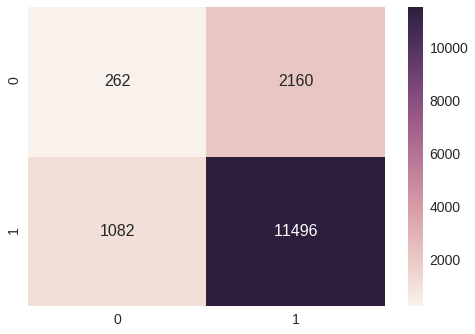

In [0]:
df_cm = pd.DataFrame(confusion_matrix(bow_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (BOW)
tfidf_train = np.load("drive/ai/tfidf_train.npy")
tfidf_train_y = np.load("drive/ai/tfidf_train_y.npy")
tfidf_cv = np.load("drive/ai/tfidf_cv.npy")
tfidf_cv_y = np.load("drive/ai/tfidf_cv_y.npy")
tfidf_test = np.load("drive/ai/tfidf_test.npy")
tfidf_test_y = np.load("drive/ai/tfidf_test_y.npy")

In [0]:
print("Shape of Train = ", tfidf_train.shape)
print("Shape of CV = ", tfidf_cv.shape)
print("Shape of Test = ", tfidf_test.shape)

Shape of Train =  (24500, 500)
Shape of CV =  (10500, 500)
Shape of Test =  (15000, 500)


In [0]:
tfidf_train_auc = []
tfidf_cv_auc = []
for i in range(1,10,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(tfidf_train, tfidf_train_y)
  # train data
  y_prob_train = knn.predict_proba(tfidf_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(tfidf_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  tfidf_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(tfidf_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(tfidf_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  tfidf_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 49.98%

Train AUC for k = 3 is 91.10%

CV AUC for k = 3 is 50.77%

Train AUC for k = 5 is 83.34%

CV AUC for k = 5 is 50.96%

Train AUC for k = 7 is 80.95%

CV AUC for k = 7 is 51.01%

Train AUC for k = 9 is 79.26%

CV AUC for k = 9 is 51.53%


In [0]:
k_values = [j for j in range(1,10,2)]

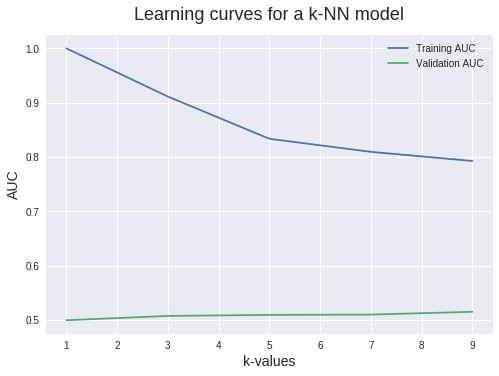

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, tfidf_train_auc, label = 'Training AUC')
plt.plot(k_values, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(tfidf_train, tfidf_train_y)
# train data
y_prob_train = knn.predict_proba(tfidf_train)[:,1]
fprt, tprt , throsholdt = roc_curve(tfidf_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(tfidf_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(tfidf_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(tfidf_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(tfidf_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (9, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(tfidf_test)[:,1]
fprts, tprts , throsholdts = roc_curve(tfidf_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(tfidf_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 9 is 79.26%

CV AUC for k = 97 is 51.53%

Test AUC for k = 97 is 51.78%


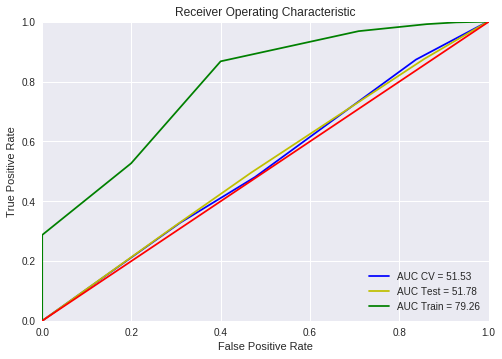

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(tfidf_test_y, y_pred_test)))

F1-Score on test set: 0.91


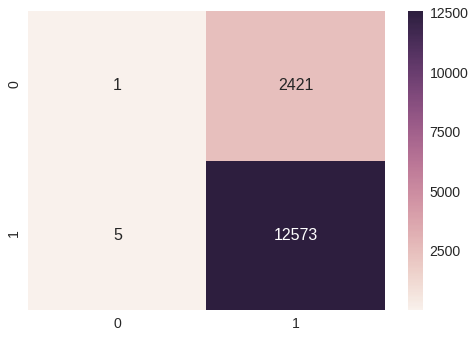

In [0]:
df_cm = pd.DataFrame(confusion_matrix(tfidf_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (w2v)
w2v_train = np.load("drive/ai/w2v_train.npy")
w2v_train_y = np.load("drive/ai/w2v_train_y.npy")
w2v_cv = np.load("drive/ai/w2v_cv.npy")
w2v_cv_y = np.load("drive/ai/w2v_cv_y.npy")
w2v_test = np.load("drive/ai/w2v_test.npy")
w2v_test_y = np.load("drive/ai/w2v_test_y.npy")

In [0]:
print("Shape of Train = ", w2v_train.shape)
print("Shape of CV = ", w2v_cv.shape)
print("Shape of Test = ", w2v_test.shape)

Shape of Train =  (24500, 50)
Shape of CV =  (10500, 50)
Shape of Test =  (15000, 50)


In [0]:
w2v_train_auc = []
w2v_cv_auc = []
for i in range(1,40,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(w2v_train, w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 66.50%

Train AUC for k = 3 is 95.18%

CV AUC for k = 3 is 75.20%

Train AUC for k = 5 is 93.10%

CV AUC for k = 5 is 79.20%

Train AUC for k = 7 is 92.02%

CV AUC for k = 7 is 81.47%

Train AUC for k = 9 is 91.48%

CV AUC for k = 9 is 82.27%

Train AUC for k = 11 is 91.01%

CV AUC for k = 11 is 82.93%

Train AUC for k = 13 is 90.63%

CV AUC for k = 13 is 83.80%

Train AUC for k = 15 is 90.24%

CV AUC for k = 15 is 84.16%

Train AUC for k = 17 is 89.95%

CV AUC for k = 17 is 84.47%

Train AUC for k = 19 is 89.69%

CV AUC for k = 19 is 84.94%

Train AUC for k = 21 is 89.50%

CV AUC for k = 21 is 85.12%

Train AUC for k = 23 is 89.32%

CV AUC for k = 23 is 85.38%

Train AUC for k = 25 is 89.12%

CV AUC for k = 25 is 85.49%

Train AUC for k = 27 is 89.02%

CV AUC for k = 27 is 85.62%

Train AUC for k = 29 is 88.97%

CV AUC for k = 29 is 85.66%

Train AUC for k = 31 is 88.94%

CV AUC for k = 31 is 85.79%

Train AUC for k = 33 is 88.93%

C

In [0]:
for i in range(41,50,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(w2v_train, w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 41 is 88.68%

CV AUC for k = 41 is 86.31%

Train AUC for k = 43 is 88.57%

CV AUC for k = 43 is 86.35%

Train AUC for k = 45 is 88.50%

CV AUC for k = 45 is 86.36%

Train AUC for k = 47 is 88.44%

CV AUC for k = 47 is 86.45%

Train AUC for k = 49 is 88.37%

CV AUC for k = 49 is 86.47%


In [0]:
for i in range(51,70,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(w2v_train, w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 51 is 88.36%

CV AUC for k = 51 is 86.48%

Train AUC for k = 53 is 88.32%

CV AUC for k = 53 is 86.48%

Train AUC for k = 55 is 88.30%

CV AUC for k = 55 is 86.56%

Train AUC for k = 57 is 88.17%

CV AUC for k = 57 is 86.56%

Train AUC for k = 59 is 88.13%

CV AUC for k = 59 is 86.60%

Train AUC for k = 61 is 88.11%

CV AUC for k = 61 is 86.59%

Train AUC for k = 63 is 88.10%

CV AUC for k = 63 is 86.61%

Train AUC for k = 65 is 88.04%

CV AUC for k = 65 is 86.59%

Train AUC for k = 67 is 88.01%

CV AUC for k = 67 is 86.64%

Train AUC for k = 69 is 87.97%

CV AUC for k = 69 is 86.68%


In [0]:
for i in range(71,100,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(w2v_train, w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 71 is 87.95%

CV AUC for k = 71 is 86.67%

Train AUC for k = 73 is 87.90%

CV AUC for k = 73 is 86.67%

Train AUC for k = 75 is 87.89%

CV AUC for k = 75 is 86.63%

Train AUC for k = 77 is 87.87%

CV AUC for k = 77 is 86.65%

Train AUC for k = 79 is 87.85%

CV AUC for k = 79 is 86.70%

Train AUC for k = 81 is 87.81%

CV AUC for k = 81 is 86.69%

Train AUC for k = 83 is 87.81%

CV AUC for k = 83 is 86.72%

Train AUC for k = 85 is 87.77%

CV AUC for k = 85 is 86.75%

Train AUC for k = 87 is 87.75%

CV AUC for k = 87 is 86.77%

Train AUC for k = 89 is 87.74%

CV AUC for k = 89 is 86.75%

Train AUC for k = 91 is 87.72%

CV AUC for k = 91 is 86.80%

Train AUC for k = 93 is 87.70%

CV AUC for k = 93 is 86.82%

Train AUC for k = 95 is 87.69%

CV AUC for k = 95 is 86.84%

Train AUC for k = 97 is 87.70%

CV AUC for k = 97 is 86.87%

Train AUC for k = 99 is 87.67%

CV AUC for k = 99 is 86.86%


In [0]:
k_values = [j for j in range(1,100,2)]

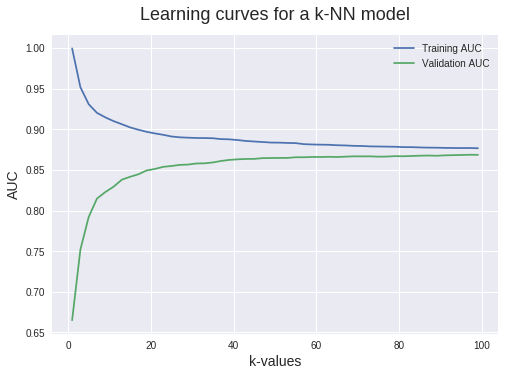

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, w2v_train_auc, label = 'Training AUC')
plt.plot(k_values, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=97)
knn.fit(w2v_train, w2v_train_y)
# train data
y_prob_train = knn.predict_proba(w2v_train)[:,1]
fprt, tprt , throsholdt = roc_curve(w2v_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(w2v_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (97, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(w2v_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (97, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(w2v_test)[:,1]
fprts, tprts , throsholdts = roc_curve(w2v_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(w2v_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (97, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 97 is 87.70%

CV AUC for k = 97 is 86.87%

Test AUC for k = 97 is 86.76%


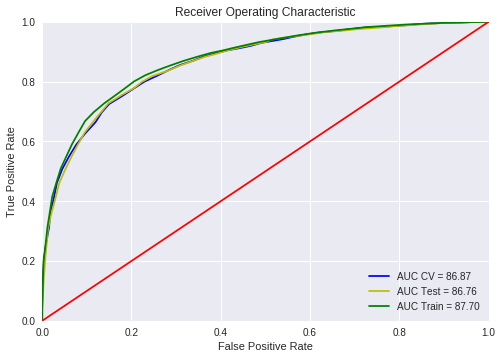

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(w2v_test_y, y_pred_test)))

F1-Score on test set: 0.92


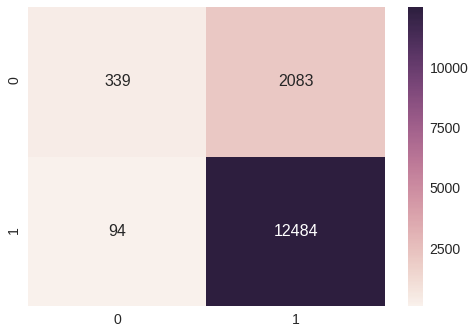

In [0]:
df_cm = pd.DataFrame(confusion_matrix(w2v_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (w2v)
tfidf_w2v_train = np.load("drive/ai/w2v_tfidf_train.npy")
tfidf_w2v_train_y = np.load("drive/ai/w2v_tfidf_train_y.npy")
tfidf_w2v_cv = np.load("drive/ai/w2v_tfidf_cv.npy")
tfidf_w2v_cv_y = np.load("drive/ai/w2v_tfidf_cv_y.npy")
tfidf_w2v_test = np.load("drive/ai/w2v_tfidf_test.npy")
tfidf_w2v_test_y = np.load("drive/ai/w2v_tfidf_test_y.npy")

In [0]:
print("Shape of Train = ", tfidf_w2v_train.shape)
print("Shape of CV = ", tfidf_w2v_cv.shape)
print("Shape of Test = ", tfidf_w2v_test.shape)

Shape of Train =  (24500, 50)
Shape of CV =  (10500, 50)
Shape of Test =  (15000, 50)


In [0]:
tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in range(1,50,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(tfidf_w2v_train, tfidf_w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(tfidf_w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(tfidf_w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  tfidf_w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(tfidf_w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(tfidf_w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  tfidf_w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 62.63%

Train AUC for k = 3 is 94.05%

CV AUC for k = 3 is 71.66%

Train AUC for k = 5 is 91.67%

CV AUC for k = 5 is 75.75%

Train AUC for k = 7 is 90.30%

CV AUC for k = 7 is 77.93%

Train AUC for k = 9 is 89.37%

CV AUC for k = 9 is 79.13%

Train AUC for k = 11 is 88.58%

CV AUC for k = 11 is 79.50%

Train AUC for k = 13 is 88.04%

CV AUC for k = 13 is 80.21%

Train AUC for k = 15 is 87.66%

CV AUC for k = 15 is 80.56%

Train AUC for k = 17 is 87.48%

CV AUC for k = 17 is 80.81%

Train AUC for k = 19 is 87.35%

CV AUC for k = 19 is 80.97%

Train AUC for k = 21 is 87.16%

CV AUC for k = 21 is 81.16%

Train AUC for k = 23 is 87.00%

CV AUC for k = 23 is 81.40%

Train AUC for k = 25 is 86.82%

CV AUC for k = 25 is 81.36%

Train AUC for k = 27 is 86.57%

CV AUC for k = 27 is 81.53%

Train AUC for k = 29 is 86.44%

CV AUC for k = 29 is 81.59%

Train AUC for k = 31 is 86.28%

CV AUC for k = 31 is 81.87%

Train AUC for k = 33 is 86.17%

C

In [0]:
k_values = [j for j in range(1,50,2)]

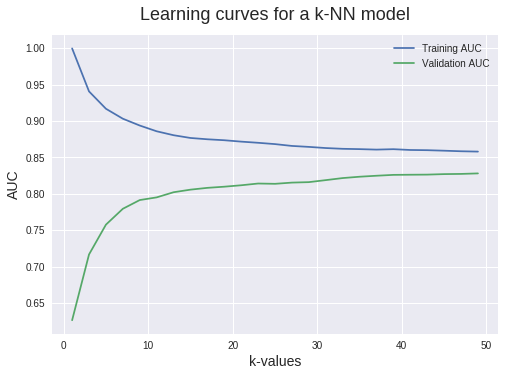

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

plt.style.use('seaborn')

plt.plot(k_values, tfidf_w2v_train_auc, label = 'Training AUC')
plt.plot(k_values, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=49)
knn.fit(tfidf_w2v_train, tfidf_w2v_train_y)
# train data
y_prob_train = knn.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt , throsholdt = roc_curve(tfidf_w2v_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(tfidf_w2v_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (49, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(tfidf_w2v_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(tfidf_w2v_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (49, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts , throsholdts = roc_curve(tfidf_w2v_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(tfidf_w2v_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (97, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 49 is 85.79%

CV AUC for k = 49 is 82.79%

Test AUC for k = 97 is 82.76%


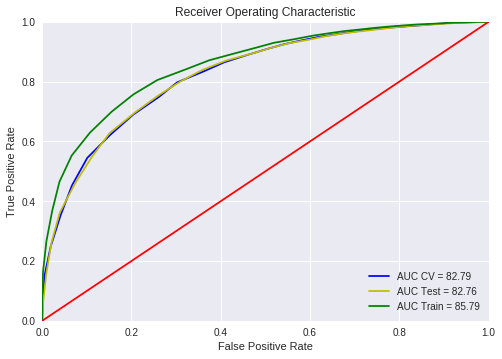

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(tfidf_w2v_test_y, y_pred_test)))

F1-Score on test set: 0.92


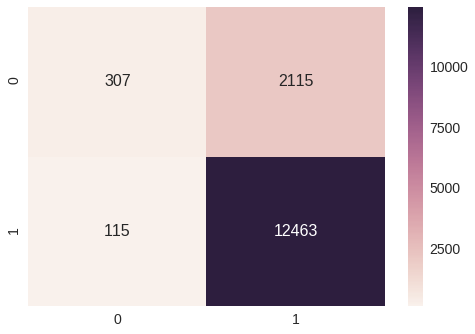

In [0]:
df_cm = pd.DataFrame(confusion_matrix(tfidf_w2v_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (BOW)
kd_bow_train = np.load("drive/ai/kd_bow_train.npy")
kd_bow_train_y = np.load("drive/ai/kd_bow_train_y.npy")
kd_bow_cv = np.load("drive/ai/kd_bow_cv.npy")
kd_bow_cv_y = np.load("drive/ai/kd_bow_cv_y.npy")
kd_bow_test = np.load("drive/ai/kd_bow_test.npy")
kd_bow_test_y = np.load("drive/ai/kd_bow_test_y.npy")

In [0]:
print("Shape of Train = ", kd_bow_train.shape)
print("Shape of CV = ", kd_bow_cv.shape)
print("Shape of Test = ", kd_bow_test.shape)

Shape of Train =  (24500, 200)
Shape of CV =  (10500, 200)
Shape of Test =  (15000, 200)


In [0]:
bow_train_auc = []
bow_cv_auc = []
for i in range(1,20,2):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
  knn.fit(kd_bow_train, kd_bow_train_y)
  # train data
  y_prob_train = knn.predict_proba(kd_bow_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(kd_bow_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  bow_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(kd_bow_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(kd_bow_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  bow_cv_auc.append(auc_roc_cv)
  
  
  


Train AUC for k = 1 is 99.89%

CV AUC for k = 1 is 55.49%

Train AUC for k = 3 is 92.33%

CV AUC for k = 3 is 59.16%

Train AUC for k = 5 is 89.09%

CV AUC for k = 5 is 60.28%

Train AUC for k = 7 is 87.52%

CV AUC for k = 7 is 61.62%

Train AUC for k = 9 is 86.61%

CV AUC for k = 9 is 62.11%

Train AUC for k = 11 is 85.79%

CV AUC for k = 11 is 62.28%

Train AUC for k = 13 is 84.96%

CV AUC for k = 13 is 62.50%

Train AUC for k = 15 is 84.59%

CV AUC for k = 15 is 62.82%

Train AUC for k = 17 is 84.22%

CV AUC for k = 17 is 62.82%

Train AUC for k = 19 is 83.84%

CV AUC for k = 19 is 62.86%


In [0]:
k_values = [j for j in range(1,20,2)]

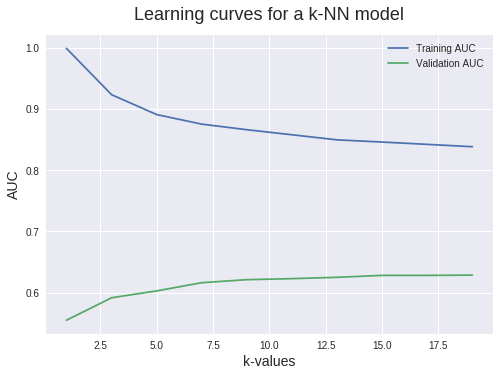

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, bow_train_auc, label = 'Training AUC')
plt.plot(k_values, bow_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=19 , algorithm="kd_tree")
knn.fit(kd_bow_train, kd_bow_train_y)
# train data
y_prob_train = knn.predict_proba(kd_bow_train)[:,1]
fprt, tprt , throsholdt = roc_curve(kd_bow_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(kd_bow_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (19, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(kd_bow_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(kd_bow_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(kd_bow_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (19, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(kd_bow_test)[:,1]
fprts, tprts , throsholdts = roc_curve(kd_bow_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(kd_bow_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (19, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 19 is 83.84%

CV AUC for k = 19 is 62.86%

Test AUC for k = 19 is 57.44%


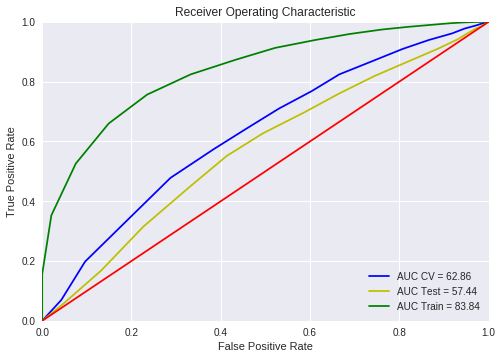

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(kd_bow_test_y, y_pred_test)))

F1-Score on test set: 0.86


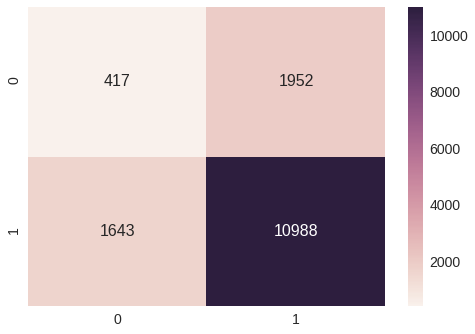

In [0]:
df_cm = pd.DataFrame(confusion_matrix(kd_bow_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (BOW)
kd_tfidf_train = np.load("drive/ai/kd_tfidf_train.npy")
kd_tfidf_train_y = np.load("drive/ai/kd_tfidf_train_y.npy")
kd_tfidf_cv = np.load("drive/ai/kd_tfidf_cv.npy")
kd_tfidf_cv_y = np.load("drive/ai/kd_tfidf_cv_y.npy")
kd_tfidf_test = np.load("drive/ai/kd_tfidf_test.npy")
kd_tfidf_test_y = np.load("drive/ai/kd_tfidf_test_y.npy")

In [65]:
print("Shape of Train = ", kd_tfidf_train.shape)
print("Shape of CV = ", kd_tfidf_cv.shape)
print("Shape of Test = ", kd_tfidf_test.shape)

Shape of Train =  (24500, 200)
Shape of CV =  (10500, 200)
Shape of Test =  (15000, 200)


In [66]:
tfidf_train_auc = []
tfidf_cv_auc = []
for i in range(1,10,2):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
  knn.fit(kd_tfidf_train, kd_tfidf_train_y)
  # train data
  y_prob_train = knn.predict_proba(kd_tfidf_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(kd_tfidf_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  tfidf_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(kd_tfidf_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(kd_tfidf_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  tfidf_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.89%

CV AUC for k = 1 is 56.31%

Train AUC for k = 3 is 92.03%

CV AUC for k = 3 is 60.04%

Train AUC for k = 5 is 89.02%

CV AUC for k = 5 is 61.82%

Train AUC for k = 7 is 87.35%

CV AUC for k = 7 is 63.19%

Train AUC for k = 9 is 86.26%

CV AUC for k = 9 is 63.70%


In [0]:
k_values = [j for j in range(1,10,2)]

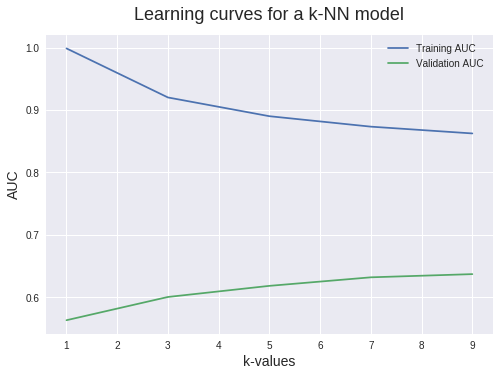

In [68]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, tfidf_train_auc, label = 'Training AUC')
plt.plot(k_values, tfidf_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [71]:
knn = KNeighborsClassifier(n_neighbors=9, algorithm="kd_tree")
knn.fit(kd_tfidf_train, kd_tfidf_train_y)
# train data
y_prob_train = knn.predict_proba(kd_tfidf_train)[:,1]
fprt, tprt , throsholdt = roc_curve(kd_tfidf_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(kd_tfidf_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(kd_tfidf_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(kd_tfidf_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(kd_tfidf_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (9, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(kd_tfidf_test)[:,1]
fprts, tprts , throsholdts = roc_curve(kd_tfidf_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(kd_tfidf_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (9, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 9 is 86.26%

CV AUC for k = 9 is 63.70%

Test AUC for k = 9 is 60.71%


In [73]:
print("F1-Score on test set: %0.2f"%(f1_score(kd_tfidf_test_y, y_pred_test)))

F1-Score on test set: 0.89


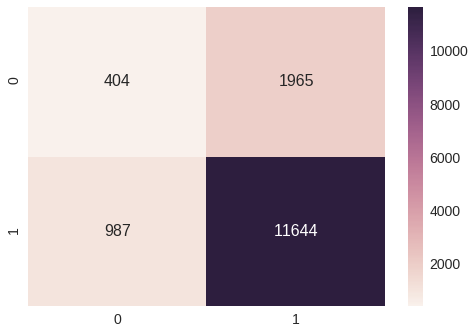

In [74]:
df_cm = pd.DataFrame(confusion_matrix(kd_tfidf_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (w2v)
w2v_train = np.load("drive/ai/w2v_train.npy")
w2v_train_y = np.load("drive/ai/w2v_train_y.npy")
w2v_cv = np.load("drive/ai/w2v_cv.npy")
w2v_cv_y = np.load("drive/ai/w2v_cv_y.npy")
w2v_test = np.load("drive/ai/w2v_test.npy")
w2v_test_y = np.load("drive/ai/w2v_test_y.npy")

In [0]:
print("Shape of Train = ", w2v_train.shape)
print("Shape of CV = ", w2v_cv.shape)
print("Shape of Test = ", w2v_test.shape)

Shape of Train =  (24500, 50)
Shape of CV =  (10500, 50)
Shape of Test =  (15000, 50)


In [0]:
w2v_train_auc = []
w2v_cv_auc = []
for i in range(1,100,2):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm="kd_tree")
  knn.fit(w2v_train, w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 66.50%

Train AUC for k = 3 is 95.18%

CV AUC for k = 3 is 75.20%

Train AUC for k = 5 is 93.10%

CV AUC for k = 5 is 79.20%

Train AUC for k = 7 is 92.02%

CV AUC for k = 7 is 81.47%

Train AUC for k = 9 is 91.48%

CV AUC for k = 9 is 82.27%

Train AUC for k = 11 is 91.01%

CV AUC for k = 11 is 82.93%

Train AUC for k = 13 is 90.63%

CV AUC for k = 13 is 83.80%

Train AUC for k = 15 is 90.24%

CV AUC for k = 15 is 84.16%

Train AUC for k = 17 is 89.95%

CV AUC for k = 17 is 84.47%

Train AUC for k = 19 is 89.69%

CV AUC for k = 19 is 84.94%

Train AUC for k = 21 is 89.50%

CV AUC for k = 21 is 85.12%

Train AUC for k = 23 is 89.32%

CV AUC for k = 23 is 85.38%

Train AUC for k = 25 is 89.12%

CV AUC for k = 25 is 85.49%

Train AUC for k = 27 is 89.02%

CV AUC for k = 27 is 85.62%

Train AUC for k = 29 is 88.97%

CV AUC for k = 29 is 85.66%

Train AUC for k = 31 is 88.94%

CV AUC for k = 31 is 85.79%

Train AUC for k = 33 is 88.93%

C

In [0]:
k_values = [j for j in range(1,100,2)]

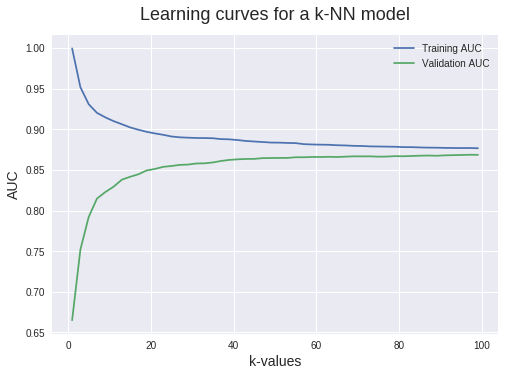

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

plt.plot(k_values, w2v_train_auc, label = 'Training AUC')
plt.plot(k_values, w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=97, algorithm="kd_tree")
knn.fit(w2v_train, w2v_train_y)
# train data
y_prob_train = knn.predict_proba(w2v_train)[:,1]
fprt, tprt , throsholdt = roc_curve(w2v_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(w2v_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (97, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(w2v_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(w2v_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(w2v_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (97, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(w2v_test)[:,1]
fprts, tprts , throsholdts = roc_curve(w2v_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(w2v_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (97, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 97 is 87.67%

CV AUC for k = 97 is 86.87%

Test AUC for k = 97 is 86.76%


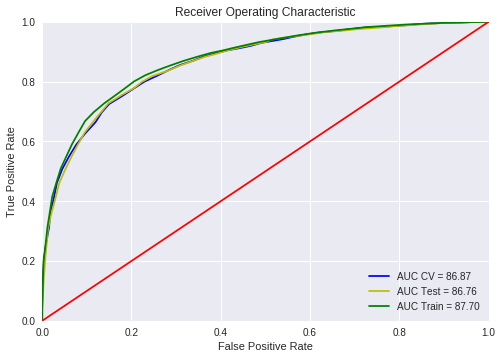

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
print("F1-Score on test set: %0.2f"%(f1_score(w2v_test_y, y_pred_test)))

F1-Score on test set: 0.92


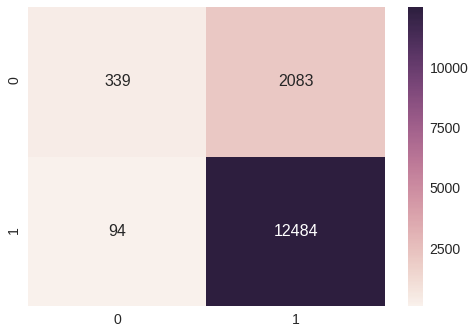

In [0]:
df_cm = pd.DataFrame(confusion_matrix(w2v_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
# Please write all the code with proper documentation
# load Review text, preprocessed one converted into vectors using (w2v)
tfidf_w2v_train = np.load("drive/ai/w2v_tfidf_train.npy")
tfidf_w2v_train_y = np.load("drive/ai/w2v_tfidf_train_y.npy")
tfidf_w2v_cv = np.load("drive/ai/w2v_tfidf_cv.npy")
tfidf_w2v_cv_y = np.load("drive/ai/w2v_tfidf_cv_y.npy")
tfidf_w2v_test = np.load("drive/ai/w2v_tfidf_test.npy")
tfidf_w2v_test_y = np.load("drive/ai/w2v_tfidf_test_y.npy")

In [0]:
print("Shape of Train = ", tfidf_w2v_train.shape)
print("Shape of CV = ", tfidf_w2v_cv.shape)
print("Shape of Test = ", tfidf_w2v_test.shape)

Shape of Train =  (24500, 50)
Shape of CV =  (10500, 50)
Shape of Test =  (15000, 50)


In [0]:
tfidf_w2v_train_auc = []
tfidf_w2v_cv_auc = []
for i in range(1,100,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(tfidf_w2v_train, tfidf_w2v_train_y)
  # train data
  y_prob_train = knn.predict_proba(tfidf_w2v_train)[:,1]
  y_pred = np.where(y_prob_train > 0.5, 1, 0)
  auc_roc_test = roc_auc_score(tfidf_w2v_train_y , y_prob_train)
  print('\nTrain AUC for k = %d is %0.2f%%' % (i, (auc_roc_test * float(100))))
  tfidf_w2v_train_auc.append(auc_roc_test)
  # CV
  y_prob_cv = knn.predict_proba(tfidf_w2v_cv)[:,1]
  y_pred = np.where(y_prob_cv > 0.5, 1, 0)
  auc_roc_cv = roc_auc_score(tfidf_w2v_cv_y , y_prob_cv)
  print('\nCV AUC for k = %d is %0.2f%%' % (i, (auc_roc_cv * float(100))))
  tfidf_w2v_cv_auc.append(auc_roc_cv)
  print("="*50)


Train AUC for k = 1 is 99.96%

CV AUC for k = 1 is 62.63%

Train AUC for k = 3 is 94.05%

CV AUC for k = 3 is 71.66%

Train AUC for k = 5 is 91.67%

CV AUC for k = 5 is 75.75%

Train AUC for k = 7 is 90.30%

CV AUC for k = 7 is 77.93%

Train AUC for k = 9 is 89.37%

CV AUC for k = 9 is 79.13%

Train AUC for k = 11 is 88.58%

CV AUC for k = 11 is 79.50%

Train AUC for k = 13 is 88.04%

CV AUC for k = 13 is 80.21%

Train AUC for k = 15 is 87.66%

CV AUC for k = 15 is 80.56%

Train AUC for k = 17 is 87.48%

CV AUC for k = 17 is 80.81%

Train AUC for k = 19 is 87.35%

CV AUC for k = 19 is 80.97%

Train AUC for k = 21 is 87.16%

CV AUC for k = 21 is 81.16%

Train AUC for k = 23 is 87.00%

CV AUC for k = 23 is 81.40%

Train AUC for k = 25 is 86.82%

CV AUC for k = 25 is 81.36%

Train AUC for k = 27 is 86.57%

CV AUC for k = 27 is 81.53%

Train AUC for k = 29 is 86.44%

CV AUC for k = 29 is 81.59%

Train AUC for k = 31 is 86.28%

CV AUC for k = 31 is 81.87%

Train AUC for k = 33 is 86.17%

C

In [0]:
k_values = [j for j in range(1,100,2)]

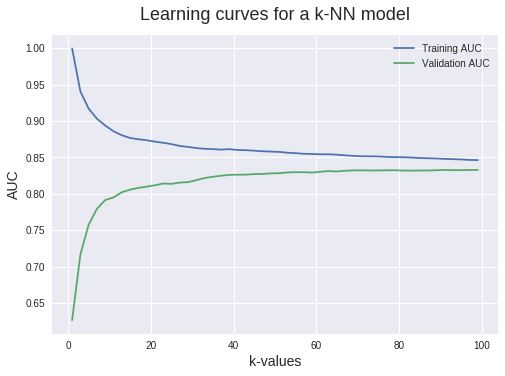

In [0]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

plt.style.use('seaborn')

plt.plot(k_values, tfidf_w2v_train_auc, label = 'Training AUC')
plt.plot(k_values, tfidf_w2v_cv_auc, label = 'Validation AUC')

plt.ylabel('AUC', fontsize = 14)
plt.xlabel('k-values', fontsize = 14)
plt.title('Learning curves for a k-NN model', fontsize = 18, y = 1.03)
plt.legend()

In [0]:
knn = KNeighborsClassifier(n_neighbors=91, algorithm="kd_tree")
knn.fit(tfidf_w2v_train, tfidf_w2v_train_y)
# train data
y_prob_train = knn.predict_proba(tfidf_w2v_train)[:,1]
fprt, tprt , throsholdt = roc_curve(tfidf_w2v_train_y, y_prob_train)
y_pred_train = np.where(y_prob_train > 0.5, 1, 0)
auc_roc_train = roc_auc_score(tfidf_w2v_train_y , y_prob_train)
print('\nTrain AUC for k = %d is %0.2f%%' % (91, (auc_roc_test * float(100))))
# CV
y_prob_cv = knn.predict_proba(tfidf_w2v_cv)[:,1]
fprc, tprc , throsholdc = roc_curve(tfidf_w2v_cv_y, y_prob_cv)
y_pred_cv = np.where(y_prob_cv > 0.5, 1, 0)
auc_roc_cv = roc_auc_score(tfidf_w2v_cv_y , y_prob_cv)
print('\nCV AUC for k = %d is %0.2f%%' % (91, (auc_roc_cv * float(100))))
# Test
y_prob_test = knn.predict_proba(tfidf_w2v_test)[:,1]
fprts, tprts , throsholdts = roc_curve(tfidf_w2v_test_y, y_prob_test)
y_pred_test = np.where(y_prob_test > 0.5, 1, 0)
auc_roc_test = roc_auc_score(tfidf_w2v_test_y , y_prob_test)
print('\nTest AUC for k = %d is %0.2f%%' % (91, (auc_roc_test * float(100))))
print("="*50)


Train AUC for k = 91 is 84.62%

CV AUC for k = 91 is 83.27%

Test AUC for k = 91 is 82.98%


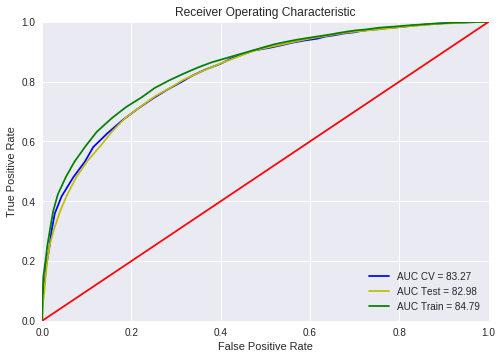

In [0]:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fprc, tprc, 'b' , label ='AUC CV = %0.2f' % (auc_roc_cv * float(100)))
plt.plot(fprts, tprts, 'y' , label ='AUC Test = %0.2f' % (auc_roc_test * float(100)))
plt.plot(fprt, tprt, 'g', label='AUC Train = %0.2f' % (auc_roc_train * float(100)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

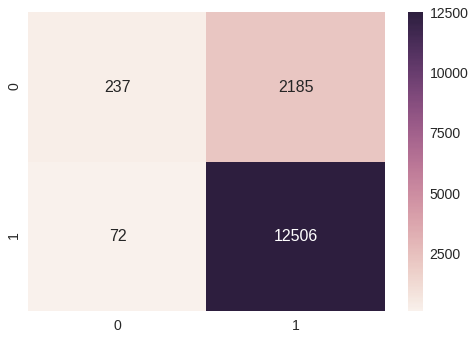

In [0]:
df_cm = pd.DataFrame(confusion_matrix(tfidf_w2v_test_y, y_pred_test), range(2), range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [78]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer", "Model", "Hyper parameter k", "AUC", "F1 Score"])

x.add_row(["BOW","Brute", 9, 0.52, 0.88])
x.add_row(["BOW","kd_tree", 19, 0.57, 0.86])
x.add_row(["TFIDF", "Brute", 9, 0.51, 0.91])
x.add_row(["TFIDF","kd_tree" , 9, 0.60, 0.89])
x.add_row(["W2V", "Brute", 97, 0.86, 0.92])
x.add_row(["W2V", "kd_tree", 97, 0.86, 0.92])
x.add_row(["TFIDFW2V", "Brute", 47, 0.82, 0.92])
x.add_row(["TFIDFW2V", "kd_tree", 91, 0.82, 0.92])

print(x.get_string(title="k-NN Model"))

+------------+---------+-------------------+------+----------+
| Vectorizer |  Model  | Hyper parameter k | AUC  | F1 Score |
+------------+---------+-------------------+------+----------+
|    BOW     |  Brute  |         9         | 0.52 |   0.88   |
|    BOW     | kd_tree |         19        | 0.57 |   0.86   |
|   TFIDF    |  Brute  |         9         | 0.51 |   0.91   |
|   TFIDF    | kd_tree |         9         | 0.6  |   0.89   |
|    W2V     |  Brute  |         97        | 0.86 |   0.92   |
|    W2V     | kd_tree |         97        | 0.86 |   0.92   |
|  TFIDFW2V  |  Brute  |         47        | 0.82 |   0.92   |
|  TFIDFW2V  | kd_tree |         91        | 0.82 |   0.92   |
+------------+---------+-------------------+------+----------+
